In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
#Run this cell for yolov9e conversion
import ast
import os
import json
all_annotations = []

#Change csv to txt first
with open('/content/drive/MyDrive/TIL_personal/results.txt', 'r') as file:
# Read the file line by line
    ctr = 0
    for line in file:
        # Print each line
        line = line.split('"')
        line = [item for item in line if item != "" and item != "," and item != "\n"]
        annotations = []
        img_name = line[-1].strip('\n,')
        line = line[:-1]
        # Use ast.literal_eval to safely evaluate the string
        for item in line:
            tuple_result = ast.literal_eval(item)

            # Extract the list of numbers and the float from the tuple
            list_of_numbers = tuple_result[0]
            confidence_score = tuple_result[1]
            annotations.append({
                "bbox": list_of_numbers,
                "conf_score": confidence_score
            })
        all_annotations.append({
            "img_name": img_name,
            "annotations": annotations
        })
        ctr += 1
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/yolo_annotations.json')
with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

In [33]:
#Run this cell for yolov6 conversion
import ast
import os
import json
all_annotations = []

#Change csv to txt first
with open('/content/drive/MyDrive/TIL_personal/results_yolov6_0.5.txt', 'r') as file:
# Read the file line by line
    ctr = 0
    for line in file:
        # Print each line
        line = line.split('"')
        line = [item for item in line if item != "" and item != "," and item != "\n"]
        annotations = []
        img_name = line[-1].strip('\n,')
        line = line[:-1]
        tuple_result = ast.literal_eval(line[0])
        for item in tuple_result:
            # Extract the list of numbers and the float from the tuple
            list_of_numbers = item[0]
            confidence_score = item[1]
            #Adjust confidence score here
            if confidence_score >= 0.25:
                annotations.append({
                    "bbox": list_of_numbers,
                    "conf_score": confidence_score
                })
        all_annotations.append({
            "img_name": img_name,
            "annotations": annotations
        })
        ctr += 1
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/yolo_annotations.json')
with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

In [34]:
import json
from collections import defaultdict
import os

def convert_json_to_coco(json_file_path, json_yolo_file_path, images):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    with open(json_yolo_file_path, 'r') as f:
        yolo_data = json.load(f)

    annotations = []
    yolo_annotations = []
    categories = [{"id": 1, "name": "object"}]  # Assuming a single category "object"
    image_id = 1
    annotation_id = 1

    img_ann = defaultdict(int)
    base_dir = "/content/drive/MyDrive/TIL_personal/data/val/images"
    for item in data:
        file_name = item['image']
        images.append({"id": image_id, "file_name": os.path.join(base_dir, file_name)})
        img_ann[item["image"]] = image_id
        for ann in item['annotations']:
            bbox = ann['bbox']
            annotations.append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": 1,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],  # width * height
                "iscrowd": 0
            })
            annotation_id += 1

        image_id += 1
    annotation_id = 1
    for item in yolo_data:
        for ann in item['annotations']:
            bbox = ann['bbox']
            bbox[2], bbox[3] = bbox[2]-bbox[0], bbox[3]-bbox[1]
            yolo_annotations.append({
                "image_id": img_ann[item["img_name"]],
                "category_id": 1,
                "bbox": bbox,
                "score": ann['conf_score']
            })
            annotation_id += 1


    return annotations, yolo_annotations, categories

# Example usage
images = []
json_annotations, json_yolo_annotations, categories = convert_json_to_coco('/content/drive/MyDrive/TIL_personal/annotations.json', '/content/drive/MyDrive/TIL_personal/yolo_annotations.json', images)

In [35]:
coco_format = {
    "images": images,
    "annotations": json_annotations,
    "categories": categories
}

with open('/content/drive/MyDrive/TIL_personal/coco_annotations.json', 'w') as f:
    json.dump(coco_format, f)

with open('/content/drive/MyDrive/TIL_personal/coco_pred_annotations.json', 'w') as f:
    json.dump(json_yolo_annotations, f)

In [36]:

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load ground truth and detection results
coco_gt = COCO('/content/drive/MyDrive/TIL_personal/coco_annotations.json')
coco_dt = coco_gt.loadRes('/content/drive/MyDrive/TIL_personal/coco_pred_annotations.json')  # Your detection results in COCO format

# Create COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Evaluate
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [37]:
#Calculate IoU@0.5 manually
#Run this before running the visualisation cells
import numpy as np
from collections import defaultdict

def convert_bbox_format(bbox):
    left, top, width, height = bbox
    right = left + width
    bottom = top + height
    return [left, top, right, bottom]

'''def img_resize(bbox):
    left, top, right, bottom = bbox
    left, right = left * (1520/1600), right * (1520/1600)
    top, bottom = top * (870/1600), bottom * (870/1600)
    return [left, top, right, bottom]'''

def calculate_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area != 0 else 0

    return iou

def match_bboxes(bboxes1, bboxes2):
    ious = np.zeros((len(bboxes1), len(bboxes2)))

    for i, box1 in enumerate(bboxes1):
        for j, box2 in enumerate(bboxes2):
            ious[i, j] = calculate_iou(box1, box2)
            #if ious[i, j] != 0:
              #print(box1, box2, ious[i, j])

    matches = []
    matched_bboxes1 = set()
    matched_bboxes2 = set()
    while True:
        max_iou = np.max(ious)
        if max_iou < 0.5:
            break

        max_idx = np.unravel_index(np.argmax(ious), ious.shape)
        i, j = max_idx

        if i not in matched_bboxes1 and j not in matched_bboxes2:
            matches.append((i, j, max_iou))
            matched_bboxes1.add(i)
            matched_bboxes2.add(j)

        ious[i, :] = -1
        ious[:, j] = -1

    return matches

def calculate_total_iou_score(all_bboxes):
    total_iou_05_score = 0
    all_boxes = 0
    for key, value in all_bboxes.items():
        if value[0] != []:
            matches = match_bboxes(value[0], value[1])
            #print(matches, len(bboxes1), len(bboxes2))
            for match in matches:
                if match[2] >= 0.5:
                    total_iou_05_score += 1
            #all_boxes += len(value[0])
            all_boxes += 4
    return total_iou_05_score/all_boxes

yolo_preds = ''
input_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/yolo_annotations.json')
with open(input_json_path, 'r') as json_file:
    yolo_preds = json.load(json_file)
ground_truth = ''
input_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')
with open(input_json_path, 'r') as json_file:
    ground_truth = json.load(json_file)
# Example usage with 600 images
# ground_truth_bboxes1 and ground_truth_bboxes2 should be lists of lists of bounding boxes for 600 images
all_bboxes = defaultdict(list)
all_conf_scores = defaultdict(list)
for instance in yolo_preds:
  bboxes = []
  conf_scores = []
  for bbox in instance["annotations"]:
    bboxes.append(bbox["bbox"])
    conf_scores.append(bbox["conf_score"])
  all_bboxes[instance["img_name"]].append(bboxes)
  all_conf_scores[instance["img_name"]] = conf_scores
ground_truth_bboxes2 = []
images = []
for instance in ground_truth:
  bboxes = []
  for bbox in instance["annotations"]:
    converted_bbox = convert_bbox_format(bbox["bbox"])
    bboxes.append(converted_bbox)
  images.append(instance["image"])
  if not all_bboxes[instance["image"]]:
    all_bboxes[instance["image"]].append([])
  all_bboxes[instance["image"]].append(bboxes)
for key, value in all_bboxes.items():
  print(key)
  print(value[0])
  print(value[1])
total_iou_05_score = calculate_total_iou_score(all_bboxes)

print(f"Total IoU@0.5 score: {total_iou_05_score}")

00000691_(3).jpg
[[1069, 437, 1191, 494], [198, 709, 310, 778], [202, 556, 330, 618], [1056, 123, 1198, 182]]
[[1072, 424, 1193, 493], [1051, 108, 1202, 194], [197, 712, 313, 778], [193, 545, 336, 627]]
00000687_(2).jpg
[[646, 457, 715, 498], [1087, 402, 1151, 447], [770, 433, 882, 488], [689, 346, 789, 398]]
[[1076, 404, 1152, 447], [766, 428, 884, 495], [651, 460, 723, 501], [678, 333, 801, 403]]
00000693.jpg
[[718, 326, 758, 361], [788, 138, 863, 176], [894, 242, 994, 292], [391, 126, 484, 187]]
[[364, 119, 492, 192], [893, 240, 999, 300], [706, 329, 763, 361], [788, 139, 852, 175]]
00000688.jpg
[[490, 729, 542, 753], [1039, 489, 1101, 529], [217, 318, 371, 391], [411, 695, 475, 732]]
[[217, 316, 366, 401], [410, 695, 475, 732], [1029, 486, 1106, 530], [490, 727, 541, 756]]
00000689.jpg
[[1085, 117, 1160, 138], [184, 721, 237, 762], [480, 446, 550, 512], [1220, 682, 1344, 761]]
[[1203, 681, 1349, 764], [170, 718, 245, 760], [1085, 107, 1161, 150], [446, 443, 561, 508]]
00000692_(2).

[543, 32, 572, 63]
[835, 639, 920, 674]
[415, 398, 530, 443]
[569, 620, 625, 652]
[1127, 577, 1236, 639]
[415, 388, 530, 454]
[832, 630, 920, 680]
00000831.jpg


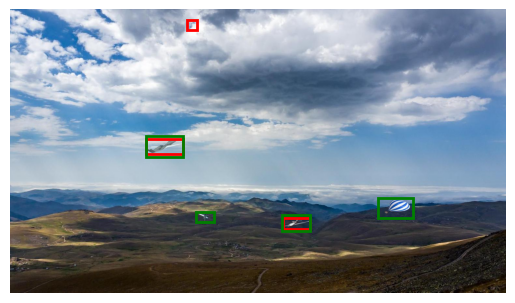

[728, 718, 779, 747]
[219, 186, 284, 212]
[1213, 585, 1334, 678]
[504, 281, 622, 336]
[1212, 584, 1361, 669]
[730, 718, 792, 753]
[219, 181, 284, 218]
[493, 268, 631, 347]
00000885.jpg


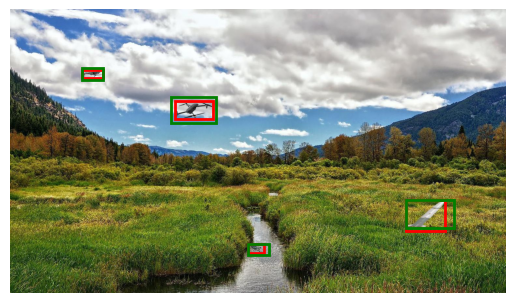

[734, 572, 800, 622]
[1209, 331, 1251, 352]
[1089, 525, 1169, 558]
[1106, 164, 1170, 206]
[732, 567, 825, 620]
[1088, 520, 1168, 565]
[1207, 328, 1253, 354]
[1085, 166, 1171, 215]
00000792_(2).jpg


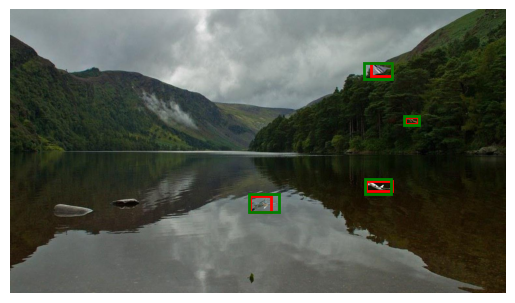

[565, 353, 652, 404]
[772, 640, 846, 686]
[977, 226, 1042, 256]
[557, 347, 661, 407]
[463, 647, 529, 685]
[767, 638, 851, 686]
[971, 218, 1049, 263]
00000794_(3).jpg


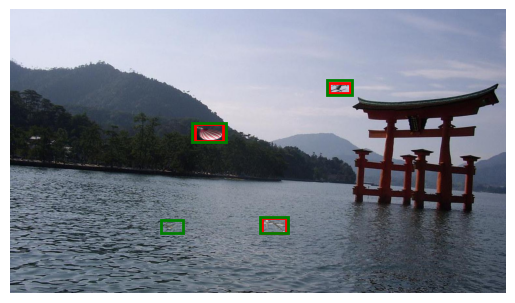

[718, 457, 783, 487]
[1209, 397, 1288, 453]
[533, 215, 608, 269]
[519, 215, 616, 270]
[707, 455, 793, 504]
[1201, 394, 1302, 452]
[1134, 406, 1183, 434]
00000857.jpg


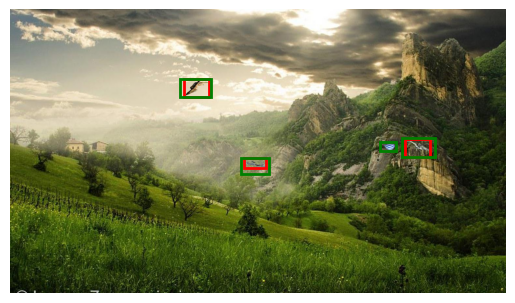

In [38]:
#Plot bboxes
import json
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths to the JSON file and the folder with the new images
images_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Select 5 random images
random_annotations = random.sample([i for i in range(0, 600)], 5)

# Function to display an image with bounding boxes
def show_image_with_bboxes(image_path, all_bboxes, image_name):
    with Image.open(image_path) as img:
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        ctr = 0
        for bbox in all_bboxes[0]:
            print(bbox)
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none')
            plt.text(bbox[0], bbox[1] - 5, f'{all_conf_scores[image_name][ctr]:.2f}', color='b', fontsize=8, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))
            ctr += 1
            ax.add_patch(rect)

        for bbox in all_bboxes[1]:
            print(bbox)
            rect2 = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect2)
        print(image_name)
        plt.axis('off')
        plt.show()

# Display the 5 selected images with their bounding boxes
for annotation in random_annotations:
    image_name = images[annotation]
    image_path = os.path.join(images_dir, image_name)
    show_image_with_bboxes(image_path, all_bboxes[image_name], image_name)

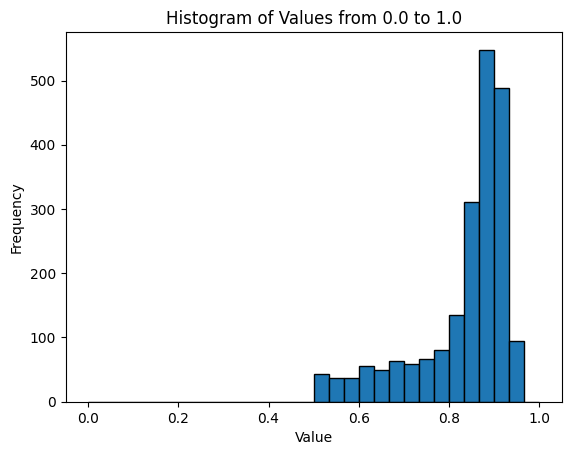

In [39]:
#Plot histogram of conf scores
import matplotlib.pyplot as plt
conf_score = []
for instance in yolo_preds:
  for bbox in instance["annotations"]:
    conf_score.append(bbox['conf_score'])
plt.hist(conf_score, bins=30, range=(0.0, 1.0), edgecolor='black')
plt.title('Histogram of Values from 0.0 to 1.0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()